In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from halp.undirected_hypergraph import UndirectedHypergraph
from halp.utilities import undirected_graph_transformations, undirected_matrices
import scipy
import time

## Configuration Model Graph: Random Walk/PageRank Correlation

In [2]:
# generating a random configuration model-esque graph for a hypergraph

N = 50
E = 7
node_deg_sequence = np.random.randint(1, E-3, np.round(N, 0))

while np.sum(node_deg_sequence) % 2 == 1:
    node_deg_sequence = np.random.randint(1, E-3, np.round(N, 0))
    
    
# randomly allocate numbers connections to the hyperedges

edge_deg = np.random.rand(E)

# round and ensure sum is equal to the node degree sequence

edge_deg = np.round((np.sum(node_deg_sequence) / edge_deg.sum())*edge_deg, 0).astype(int)

if np.sum(edge_deg) != np.sum(node_deg_sequence):
    i  = np.random.choice(range(E))
    while edge_deg[i] < 2:
        i = np.random.choice(range(E))
    edge_deg[i] += np.sum(node_deg_sequence) - np.sum(edge_deg)

In [3]:
G = nx.bipartite.configuration_model(node_deg_sequence, edge_deg)

In [4]:
node_deg_sequence

array([3, 3, 1, 2, 3, 2, 1, 1, 3, 2, 2, 3, 2, 1, 1, 3, 3, 2, 2, 2, 3, 1,
       3, 1, 1, 3, 3, 3, 3, 3, 1, 1, 1, 2, 3, 2, 3, 2, 2, 1, 3, 3, 1, 2,
       3, 3, 1, 3, 2, 1])

In [5]:
edge_deg

array([ 1, 41, 21,  2, 28,  4,  9])

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


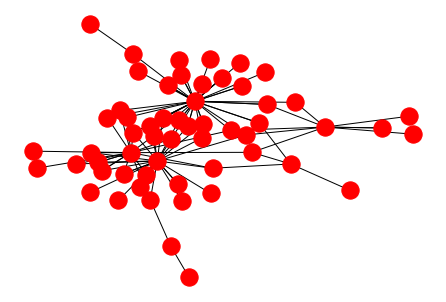

In [6]:
nx.draw(G)

In [7]:
nx.is_connected(G)

True

In [8]:
# bi-partite adjacency matrix
I = nx.bipartite.biadjacency_matrix(G, row_order=range(N)).toarray()


# since configuration model can create multiple edges, we remove these 
# because it does not make sense for a node to have multiple edges to a hyperedge

I[I > 1] = 1
I

# hyper-adjacency matrix

A = I @ I.T
A = A - np.diag(np.diag(A))
A

array([[0, 1, 0, ..., 0, 1, 1],
       [1, 0, 0, ..., 2, 2, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 2, 1, ..., 0, 1, 0],
       [1, 2, 0, ..., 1, 0, 1],
       [1, 1, 0, ..., 0, 1, 0]], dtype=int32)

In [9]:
# Clique Reduction Graph
nx_graph = nx.from_numpy_matrix(A)

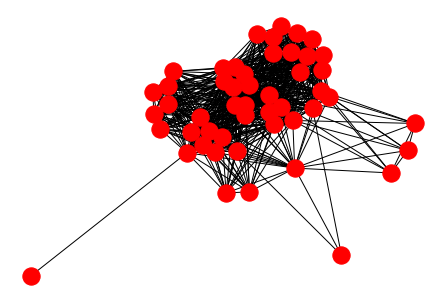

In [10]:
nx.draw(nx_graph)

In [11]:
# generalise to larger graphs

def generate_config_hgraph(N, E, sparsityfactor):
    # generating a random configuration model-esque graph for a hypergraph
    
    # generate a random degree sequence, where a node has min deg of 1 (since we want graph to be connected)
    # and max degree of sparsityfactor*E 
    # if sparsityfactor = 1, then a node could belong to all hyperedges
    
    node_deg_sequence = np.random.randint(1, np.round(sparsityfactor*E, 0).astype(int), np.round(N, 0))

#     while np.sum(node_deg_sequence) % 2 == 1:
#         node_deg_sequence = np.random.randint(1, np.round(sparsityfactor*E, 0).astype(int), np.round(N, 0))


    # randomly allocate numbers connections to the hyperedges

    edge_deg = np.random.rand(E)

    # round and ensure sum is equal to the node degree sequence

    edge_deg = 1 + np.round((np.sum(node_deg_sequence) / edge_deg.sum())*edge_deg, 0).astype(int)

    while np.sum(edge_deg) != np.sum(node_deg_sequence):
        i  = np.random.choice(range(E))
        while edge_deg[i] < 2:
            i = np.random.choice(range(E))
        edge_deg[i] += np.sum(node_deg_sequence) - np.sum(edge_deg)
    # create a bipartite graph from the degree distributions using the configuration model
        
    G = nx.bipartite.configuration_model(node_deg_sequence, edge_deg)
    
    # generate hypergraph from bipartite incidence matrix
    I = nx.bipartite.biadjacency_matrix(G, row_order=range(N)).toarray()


    # since configuration model can create multiple edges, we remove these 
    # because it does not make sense for a node to have multiple edges to a hyperedge

    I[I > 1] = 1
    
    return I

In [12]:
def power_iteration(A, num_simulations: int):

    # Code taken from "https://en.wikipedia.org/wiki/Power_iteration"
    b_k = np.random.rand(A.shape[1])

    for _ in range(num_simulations):
        # calculate the matrix-by-vector product Ab
        b_k1 = np.dot(A, b_k)

        # calculate the norm
        b_k1_norm = np.linalg.norm(b_k1, 1)

        # re normalize the vector
        b_k = b_k1 / b_k1_norm

    return b_k

def hg_pagerank_power(T, alpha, num_sims):
    nodes = list(range(len(T)))
    n = len(nodes)

    T = alpha*T + (1-alpha)/n*np.ones((n,n)) # PageRank w/ teleportation
    
    res_pgrk = power_iteration(T.T, 100) # power method
    
    return res_pgrk

In [13]:
def hg_pagerank_full_eig_decomp(T, alpha):
    """
    Not used
    
    Computes the pagerank for a Hypergraph H, for a random walk determined by transition matrix T.
    Computes by finding the left eigenvector associated to the eigenvalue \lambda = 1
    Does so by finding all eigenpairs of the matrix and then filtered
    (Takes long time for large matrices, see hg_pagerank_fast instead)
    
    """
    
    
    # p(t+1)_i = a * p(t)_i*T + (1-a)/n * 1
    
    nodes = list(range(len(T)))
    n = len(nodes)
    
    T = alpha*T + (1-alpha)/n*np.ones((n,n))
    
    # Find the right eigenvalue associated with the 1 eigenvalue (note the transpose of T)
    values, vectors = np.linalg.eig(T.T)
    vector = vectors[:,np.isclose(values, 1)] # find correct evector, code used from: 
    vector = vector[:,0]
    
    # normalise the stationary distribution
    stat_dist = vector / vector.sum()
    stat_dist = stat_dist.real
    
    
    #return the hypergraph PageRank
    return stat_dist

In [14]:
def compute_config_pgrk_correlations(num_list):
    corr_hist = []
    for N in num_list:
        I = generate_config_hgraph(N, np.round(np.sqrt(N), 0).astype(int), 0.9)
        A = I @ I.T
        A = A - np.diag(np.diag(A))
        C = I.T @ I
        C_hat = np.diag(np.diag(C))

        # compute the asymptotic walk distributions

        ##################################################################################

        # equal choice walker

        gamma = -1


        K_e = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
        C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)
        
        K_e = (I @ C_alt @ I.T).astype(float)
        K_e = K_e - np.diag(np.diag(K_e))


        T_e = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_e[i])
            if norm ==0:
                pass
            else:
                T_e[i, :] = K_e[i] / norm

        ###################################################################################

        # group-favoured choice walker

        gamma = 1

        K_n = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))

        K_n = (I @ C_alt @ I.T).astype(float)
        K_n = K_n - np.diag(np.diag(K_n))


        T_n = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_n[i])
            if norm ==0:
                pass
            else:
                T_n[i, :] = K_n[i] / norm

        ##################################################################################


        # call PageRank stationary distribution for both

        res_e = hg_pagerank_power(T_e, 0.85, 100)
        res_w = hg_pagerank_power(T_n, 0.85, 100)


        corr_hist.append(np.corrcoef(res_e, res_w)[0,1])
        
    return corr_hist

In [15]:
def compute_config_pr_correlations_slow(num_list):
    corr_hist = []
    for N in num_list:
        I = generate_config_hgraph(N, np.round(np.sqrt(N), 0).astype(int), 0.9)
        A = I @ I.T
        A = A - np.diag(np.diag(A))
        C = I.T @ I
        C_hat = np.diag(np.diag(C))

        # compute the asymptotic walk distributions

        ##################################################################################

        # equal choice walker

        gamma = -1


        K_e = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
        C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

        K_e = (I @ C_alt @ I.T).astype(float)
        K_e = K_e - np.diag(np.diag(K_e))


        T_e = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_e[i])
            if norm == 0:
                pass
            else:
                T_e[i, :] = K_e[i] / norm
            
        #T_e = np.nan_to_num(T_e, nan = 0, posinf = 0)

        ###################################################################################

        # group-favoured choice walker

        gamma = 1

        K_n = np.zeros((len(A), len(A)))
        C_alt = np.diag(np.diag((C_hat - 1).astype(float)**gamma))
        C_alt = np.nan_to_num(C_alt, nan = 0, posinf = 0)

        K_n = (I @ C_alt @ I.T).astype(float)
        K_n = K_n - np.diag(np.diag(K_n))


        T_n = np.zeros((len(A), len(A)))
        for i in range(len(A)):
            norm = np.sum(K_n[i])
            if norm == 0:
                pass
            else:
                T_n[i, :] = K_n[i] / norm
            
        #T_n = np.nan_to_num(T_n, nan = 0, posinf = 0)

        ##################################################################################


        # call PageRank stationary distribution for both

        res_e = hg_pagerank_full_eig_decomp(T_e, 0.95)
        res_w = hg_pagerank_full_eig_decomp(T_n, 0.95)


        corr_hist.append(np.corrcoef(res_e, res_w)[0,1])
        print("Completed: " + str(N))
    return corr_hist

In [25]:
# find correlations of small graphs, average over many due to speed

num_list = np.logspace(1.5, 3, 31).astype(int)

avgs = [[] for _ in range(len(num_list))]

for i in range(300):
    corr_hist2 = compute_config_pgrk_correlations(num_list)
    for j in range(len(corr_hist2)):
        if np.isnan(corr_hist2[j]):
            pass
        else:
            avgs[j].append(corr_hist2[j])

In [26]:
avgs_final = [np.mean(item) for item in avgs]

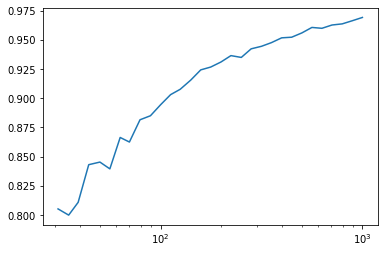

In [20]:
plt.semilogx(num_list, avgs_final)

In [28]:
# find correlations of larger graphs, only avg of 3 due to computational time required.

num_list = np.logspace(3.1, 4, 19).astype(int)

avgs2 = [[] for _ in range(len(num_list))]

for i in range(3):
    corr_hist2 = compute_config_pgrk_correlations(num_list)
    for j in range(len(corr_hist2)):
        if np.isnan(corr_hist2[j]):
            pass
        else:
            avgs2[j].append(corr_hist2[j])

In [29]:
avgs_final2 = [np.mean(item) for item in avgs2]

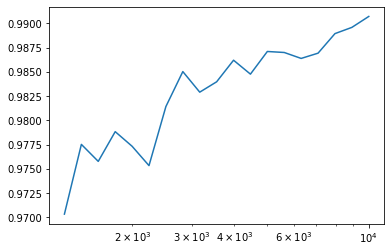

In [30]:
plt.semilogx(num_list, avgs_final2)

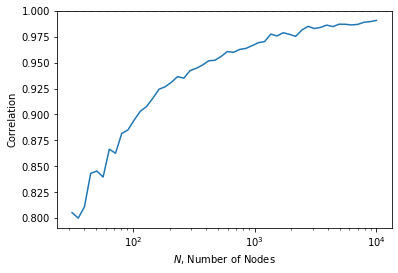

In [31]:
num_list = np.logspace(1.5, 4)

plt.semilogx(num_list, avgs_final + avgs_final2)
plt.xlabel("$N$, Number of Nodes")
plt.ylabel("Correlation")
plt.axhline(1, linestyle = "--", color = "gray")

In [32]:
conifig_walk_corr = avgs_final + avgs_final2

In [33]:
# import pickle

# with open('data/corr_r1_r_2_config_model.pkl', 'wb') as f: 
#     pickle.dump(conifig_walk_corr, f)